In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm as tqdm

from keras.models import Model,load_model

/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from src.utils import process_mnist, gen_sorted_isomap,gen_activation_functors
from src.expressivity import grassmanian_metric,curvature_length,curvature

In [4]:
_, (_,y_digit) = process_mnist(y_onehot=False)
masks = [y_digit==i for i in np.arange(10)]

subset = np.random.choice(np.arange(60000),40000)
(x_train,y_train),(x_test,y_test) = process_mnist(subset=subset)

print(x_train.shape)

X_isos = [gen_sorted_isomap(x_test[m],y_digit[m],rescale=True,n_neighbors=50,n_components=1,n_jobs=5) for m in tqdm(masks)]

  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 784)


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


In [5]:
print(len(X_isos))

10


In [7]:
X_t = [x_t for x_t,x_iso,x_c in X_isos]
X_iso = [x_iso for x_t,x_iso,x_c in X_isos]
Y_t = np.arange(10)+1
# print(X_t[3].)

In [11]:
proj_root = '/home/elijahc/projects/vae'
enc_path = os.path.join(proj_root,'models','2018-04-09','enc.h5')
enc = load_model(enc_path)
print(enc.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 209,250
Trainable params: 209,250
Non-trainable params: 0
_________________________________________________________________
None


/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


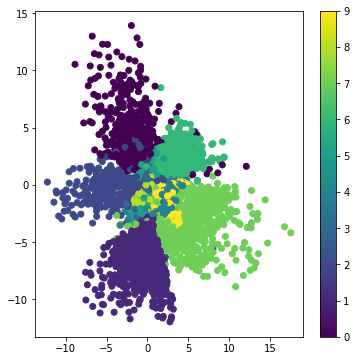

In [9]:
x_test_encoded = enc.predict(x_test,batch_size=128)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_digit)
plt.colorbar()
plt.show()

In [70]:
funcs = gen_activation_functors(enc,[1,2,3])
layer_units = [256,32,2]

In [68]:
N=None
x_t = X_t
x_iso = X_iso
label = Y_t
outs = []

In [69]:
x_t[3].shape

(1010, 784)

In [71]:
for x,iso,lab in tqdm(zip(x_t,x_iso,label)):
        x_G = grassmanian_metric(x,delta=iso).sum()
        x_K = (np.sqrt(784)*curvature(x,delta=iso)).mean()
        x_L_E = curvature_length(x,delta=iso,N=784)
        
        h_l = [f([x])[0] for f in funcs]
        
        y_K = [(np.sqrt(N)*curvature(g,iso)) for g,N in zip(h_l,layer_units)]
        y_L_E = [curvature_length(g,iso,N=N) for g,N in zip(h_l,layer_units)]
        y_G = [grassmanian_metric(g,iso).sum() for g,N in zip(h_l,layer_units)]
        
        for l_idx,G,K,L_E in zip(np.arange(len(y_G)),y_G,y_K,y_L_E):
            rec = {
                'Grassmanian Length':G,
                'Mean Curvature': K.mean(),
                'K_delta': (x_K-K).mean(),
                'x_K':x_K,
                'x_G':x_G,
                'x_L_E':x_L_E,
                'Curvature Length':L_E,
                'L_E_delta':x_L_E-L_E,
                'Layer': l_idx+1,
                'label':lab,
                'G_delta':x_G-G
            }
            outs.append(rec)

0it [00:00, ?it/s]/home/elijahc/projects/vae/notebooks/src/expressivity.py:31: RuntimeWarning: invalid value encountered in sqrt
  k[i] = ( vv[i]**-(3/2))*np.sqrt(( vv[i]*aa)-va**2)
10it [00:03,  3.13it/s]


In [78]:
df = pd.DataFrame.from_records(outs)
df.head()

,Curvature Length,G_delta,Grassmanian Length,K_delta,L_E_delta,Layer,Mean Curvature,label,x_G,x_K,x_L_E
0,3298.035435,-9.480240e+09,1.709740e+10,4.879066,-1628.992697,1,28.883419,1,7.617156e+09,33.762482,1669.042738
1,5691.214568,-5.161695e+10,5.923411e+10,-0.000550,-4022.171830,2,33.763035,1,7.617156e+09,33.762482,1669.042738
2,7740.553410,NaN,NaN,NaN,-6071.510672,3,NaN,1,7.617156e+09,33.762482,1669.042738
3,3560.243607,-2.904435e+09,2.805986e+10,39.721977,-1561.874657,1,75.853455,2,2.515542e+10,115.575439,1998.368950
4,8576.661880,-6.789448e+09,3.194487e+10,81.164604,-6578.292930,2,34.410828,2,2.515542e+10,115.575439,1998.368950


In [89]:
df['Grassmanian Length'].describe()

count    2.400000e+01
mean     1.399689e+13
std      6.422390e+13
min      4.713741e+08
25%      9.791735e+09
50%      3.724320e+10
75%      9.102150e+10
max      3.150636e+14
Name: Grassmanian Length, dtype: float64

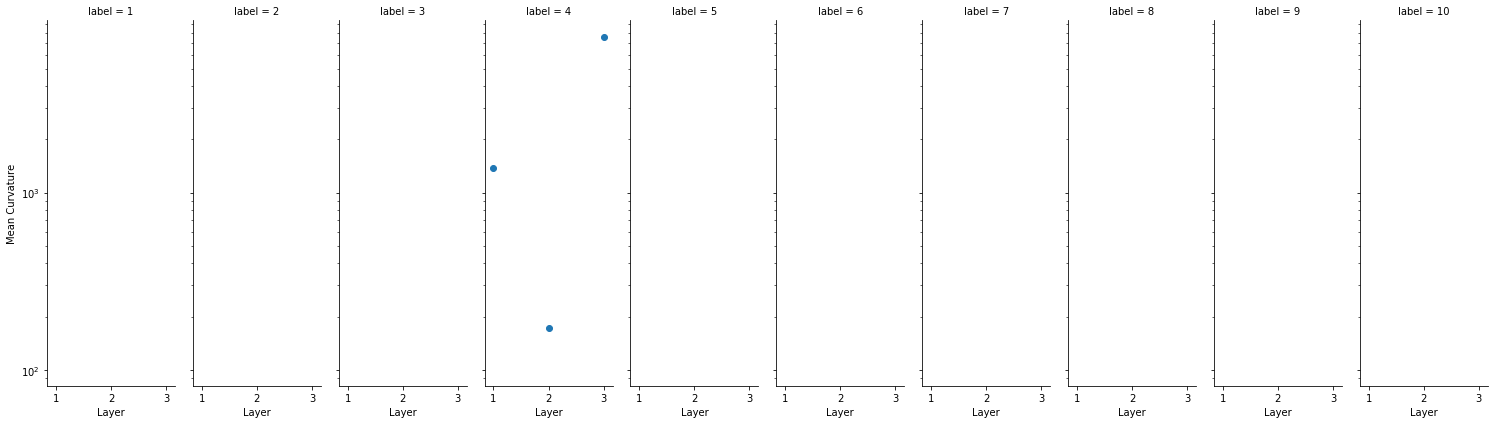

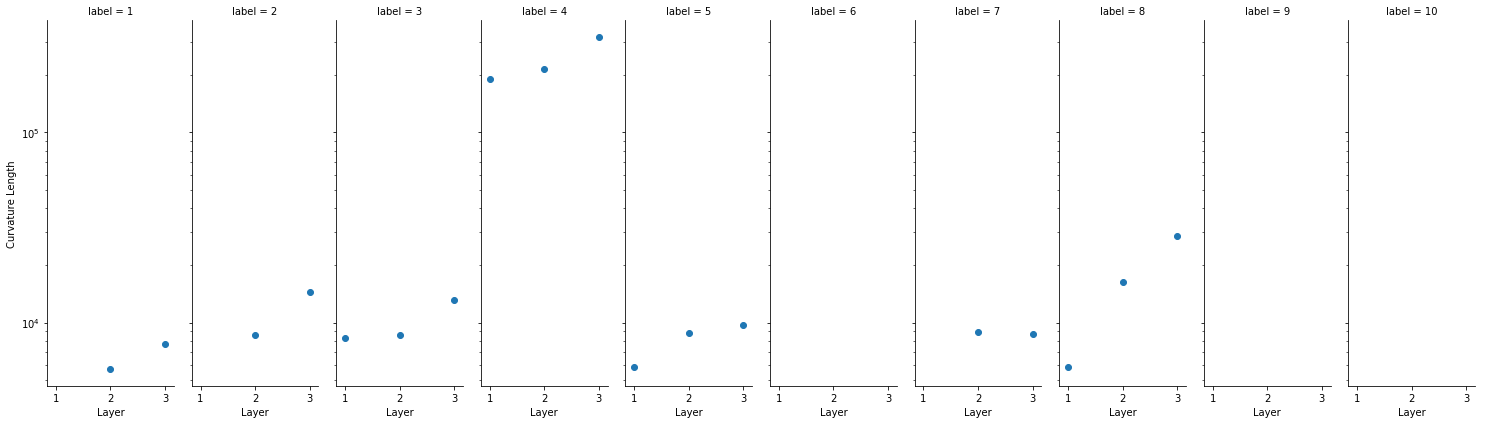

In [97]:
g = sns.FacetGrid(df,col='label',
#                   col='Stage',
                  size=6,
                  aspect=0.35,
#                   ylim=(10**0,10**3),
                 )
# g = g.map(plt.hlines,"x_G",xmin=0,xmax=3,linestyle='dashed',color='k')
g = g.map(plt.scatter,"Layer",'Mean Curvature')
plt.yscale('log')

g = sns.FacetGrid(df,col='label',
#                   col='Stage',
                  size=6,
                  aspect=0.35,
#                   ylim=(10**0,10**3),
                 )
# g = g.map(plt.hlines,"x_G",xmin=0,xmax=3,linestyle='dashed',color='k')
g = g.map(plt.scatter,"Layer",'Curvature Length')
plt.yscale('log')

In [74]:
df[df.label==1]

,Curvature Length,G_delta,Grassmanian Length,K_delta,L_E_delta,Layer,Mean Curvature,label,x_G,x_K,x_L_E
0,3298.035435,-9.480240e+09,1.709740e+10,4.879066,-1628.992697,1,28.883419,1,7.617156e+09,33.762482,1669.042738
1,5691.214568,-5.161695e+10,5.923411e+10,-0.000550,-4022.171830,2,33.763035,1,7.617156e+09,33.762482,1669.042738
2,7740.553410,NaN,NaN,NaN,-6071.510672,3,NaN,1,7.617156e+09,33.762482,1669.042738
